In [1]:
%%capture
!pip install --upgrade einops optax equinox distrax jaxopt jax-tqdm

In [2]:
from jax import random, value_and_grad, lax
from optax import adam, sgd, apply_updates, chain, clip, softmax_cross_entropy_with_integer_labels
from einops import rearrange, reduce, repeat
from functools import partial
from tqdm.notebook import tqdm
import equinox as eqx
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.random import split, normal, randint
from jax import lax, vmap, checkpoint
from distrax import Normal, Bernoulli
from jax.nn import relu, gelu, sigmoid
from jax import disable_jit
from jaxopt import FixedPointIteration
from jax.tree_util import tree_map, tree_leaves
import jax
from jax_tqdm import scan_tqdm
from jax import lax
import jax.numpy as jnp

# Typing 
from jax import Array
from typing import Optional, Sequence, Tuple, Any
from jax.random import PRNGKeyArray

SEED = 0
MODEL_KEY = random.PRNGKey(SEED)
TEST_KEY = random.PRNGKey(SEED + 1)
TRAIN_KEY = random.PRNGKey(SEED + 2)

import copy
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
def extraction(image, label):
    # This function will shrink the Omniglot images to the desired size,
    # scale pixel values and convert the RGB image to grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    return image, label

In [4]:
with jax.default_device(jax.devices("cpu")[0]):
    # Load the dataset
    train, test = tfds.load("omniglot", split=["train","test"], data_dir="data", as_supervised=True, shuffle_files=False)


    train = train.map(extraction,num_parallel_calls=tf.data.AUTOTUNE)  # works with GPU
    train_img, train_labels = [jnp.array(i) for i in list(zip(*train.as_numpy_iterator()))]
    train_img = rearrange(train_img,"b h w c -> b c h w")

    test = test.map(extraction)  # works with GPU
    test_img, test_labels = [jnp.array(i) for i in list(zip(*test.as_numpy_iterator()))]
    test_img = rearrange(test_img,"b h w c -> b c h w")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/19280 [00:00<?, ? examples/s]

Shuffling data/omniglot/3.0.0.incomplete6KN4YK/omniglot-train.tfrecord*...:   0%|          | 0/19280 [00:00<?,…

Generating test examples...:   0%|          | 0/13180 [00:00<?, ? examples/s]

Shuffling data/omniglot/3.0.0.incomplete6KN4YK/omniglot-test.tfrecord*...:   0%|          | 0/13180 [00:00<?, …

Generating small1 examples...:   0%|          | 0/2720 [00:00<?, ? examples/s]

Shuffling data/omniglot/3.0.0.incomplete6KN4YK/omniglot-small1.tfrecord*...:   0%|          | 0/2720 [00:00<?,…

Generating small2 examples...:   0%|          | 0/3120 [00:00<?, ? examples/s]

Shuffling data/omniglot/3.0.0.incomplete6KN4YK/omniglot-small2.tfrecord*...:   0%|          | 0/3120 [00:00<?,…

Dataset omniglot downloaded and prepared to data/omniglot/3.0.0. Subsequent calls will reuse this data.


In [5]:
img_size = (1,28,28)

In [6]:
# sort the data set
with jax.default_device(jax.devices("cpu")[0]):
    indices_sorted_labels = sorted(range(len(train_labels)), key=lambda k: train_labels[k])
    sorted_train_labels = train_labels[jnp.array(indices_sorted_labels)]
    sorted_train = train_img[jnp.array(indices_sorted_labels)]

    indices_sorted_labels = sorted(range(len(test_labels)), key=lambda k: test_labels[k])
    sorted_test_labels = test_labels[jnp.array(indices_sorted_labels)]
    sorted_test = test_img[jnp.array(indices_sorted_labels)]

In [7]:
# meta train on the 1200 first characters
meta_train_labels = jnp.concatenate((sorted_train_labels, sorted_test_labels[0:237*20]))
meta_train = jnp.concatenate((sorted_train, sorted_test[0:237*20]))

# meta test on the remaining
meta_test_labels = sorted_test_labels[237*20:]
meta_test = sorted_test[237*20:]

In [8]:
print(meta_train_labels.shape)
print(meta_train.shape)
print(meta_test_labels.shape)
print(meta_test.shape)

(24020,)
(24020, 1, 28, 28)
(8440,)
(8440, 1, 28, 28)


In [9]:
def multi_batch_loss(model_alpha, batch_loss, batch_of_tasks, inner_step, inner_optim, inner_opt_state) -> Array:
    """Compute the loss over all models"""

    # get model_i', test_i, test_labels_i for all tasks i: # 
    train_imgs, train_labels, test_imgs, test_labels = batch_of_tasks
    # vmap over tasks inner step
    models = eqx.filter_vmap(inner_step,in_axes=(None,0,0,None,None,None))(model_alpha, train_imgs, train_labels, 
                                                                batch_loss,inner_optim, inner_opt_state)
    # sum loss_i(model_i', test_i, test_labels_i)
    return eqx.filter_vmap(batch_loss)(models, test_imgs, test_labels).sum()

In [10]:
def batch_loss(model, images: Array, labels: Array) -> Array:
    '''Compute the loss.'''

    def loss(image: Array, label: Array):
        pred = model(image)

        return  softmax_cross_entropy_with_integer_labels(pred,label)

    # Mean over the batch
    return vmap(loss)(images, labels).mean()

In [11]:
def task_update(model_alpha, train, train_labels, inner_step, inner_optim, inner_opt_state, batch_loss):
    model_i = inner_step(model_alpha, train, train_labels, batch_loss, inner_optim, inner_opt_state)  # compute model_i'
    return model_i

In [12]:
@partial(eqx.filter_jit)
def outer_step_METASGD(model_alpha, batch_loss, outer_optim, outer_opt_state,
                       inner_step, batch_of_tasks, inner_optim, inner_opt_state):
    """"""
    loss, grads = eqx.filter_value_and_grad(multi_batch_loss)(model_alpha, batch_loss, batch_of_tasks, 
                                                              inner_step, inner_optim, inner_opt_state)  # Compute loss and gradient, meta step
    updates, outer_opt_state = outer_optim.update(grads, outer_opt_state, model_alpha)  
    model_alpha = eqx.apply_updates(model_alpha, updates)  
    return loss, model_alpha, outer_opt_state

In [13]:
def inner_step_METASGD(model_alpha, train, train_labels, batch_loss, inner_optim, inner_opt_state):

    model, alpha = copy.deepcopy(model_alpha[0]), model_alpha[1] 
    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, train, train_labels)  # Compute loss and gradient
    mod_grad = tree_map(lambda x,y: x*y, grad, alpha)  # replace standard gradient with alpha*gradient (elementwise product)
    updates, opt_state = inner_optim.update(mod_grad, inner_opt_state, model)  
    model = eqx.apply_updates(model, updates)  

    return model

In [14]:
"""N-way K-shot classification tasks"""
N_CHARACTERS = 20

@partial(eqx.filter_jit)
def load_batch_of_tasks(meta_set, nr_char, nr_train, nr_test, img_size, diff, train_key):  
    # return one task with nr_char characters 
    # for each character we have nr_train train images and nr_test test images

    # diff should be 1201 if meta_set = meta_test, meta_test_labels (for meta testing!)
    # diff should be 0 if meta_set = meta_train, meta_train_labels (for meta training!)

    meta_training_images, meta_training_labels = meta_set
    
    # load nr_char random characters from the relevant labels 
    random_characters = random.choice(train_key, meta_training_labels, replace=False, shape=(nr_char,))

    keys = split(train_key, nr_char)

    def char_data(char, key, nr_train, nr_test):
        # given a character/label, return the character together with 
        # nr_train train images and nr_test test_images (randomly chosen)
        # all images should correspond to the char label 
        rel_key, sh_key = split(key)
        relevant_images = meta_training_images[N_CHARACTERS*(char-diff) + random.permutation(rel_key,N_CHARACTERS)]
        relevant_images = relevant_images[random.permutation(sh_key, N_CHARACTERS)]
        indices_K = jnp.arange(nr_train)
        indices_Kprime= jnp.arange(N_CHARACTERS-nr_test, N_CHARACTERS)
        K_images, Kprime_images = relevant_images[indices_K], relevant_images[indices_Kprime]
        return char, K_images, Kprime_images

    labels, train_imgs, test_imgs = eqx.filter_vmap(char_data,in_axes=(0,0,None,None))(random_characters, keys, nr_train, nr_test)
    
    width, height, depth = img_size

    # reshape the data (weird?)

    train_labels, test_labels = jnp.repeat(labels, nr_train), jnp.repeat(labels, nr_test)

    train_imgs = jnp.resize(train_imgs, (nr_char*nr_train, width, height, depth))
    test_imgs = jnp.resize(test_imgs, (nr_char*nr_test, width, height, depth))

    return train_imgs, train_labels, test_imgs, test_labels


In [15]:
# Load batch of tasks
nr_of_tasks = 32  # total number of tasks

train_keys = split(TRAIN_KEY,nr_of_tasks)

# task specific parameters
nr_char = 2  # number of characters
nr_train = 3  # number of training images for each character
nr_test = 5  # number of testing images for each character

# Batch: 
train_imgs, train_labels, test_imgs, test_labels = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, None,None,None, None,0))((meta_train, meta_train_labels), nr_char, nr_train, nr_test, img_size, 0, train_keys)

In [16]:
print(train_imgs.shape)
print(train_labels.shape)
print(test_imgs.shape)
print(test_labels.shape)

(32, 6, 1, 28, 28)
(32, 6)
(32, 10, 1, 28, 28)
(32, 10)


In [17]:
print(train_labels[0])

[634 634 634 265 265 265]


161


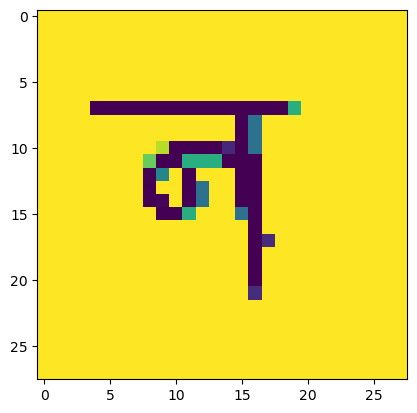

In [18]:
# indexing batch of tasks 
task, char, image =  7, 1, 2
#test_img = train_imgs[task][nr_train*char+image]
test_img = test_imgs[task][nr_test*char+image]
test_img_label = test_labels[task][nr_test*char+image]
print(test_img_label)
plt.imshow(test_img[0])
plt.show()

In [19]:
test_img.shape

(1, 28, 28)

In [20]:
# Meta training
#epochs = 4000
epochs = 60000
meta_batch_size = 32

train_keys = random.split(TRAIN_KEY, epochs)

# task specific parameters
nr_char = 5  # number of characters
nr_train = 5  # number of training images for each character
nr_test = 15  # number of testing images for each character

In [21]:
# META SGD
width, height, depth = img_size

# Initialize the optimizer


Ravel = eqx.nn.Lambda(lambda img : img.ravel())
Relu = eqx.nn.Lambda(relu)

model = eqx.nn.Sequential([Ravel,
    eqx.nn.MLP(depth*width*height,1623,64,2,key=MODEL_KEY)])

#Following [7], we use a
#convolution architecture with 4 modules, where each module consists of 3 × 3 convolutions, followed
#by batch normalization [11], a ReLU nonlinearity, and 2 × 2 max-pooling. For Omniglot, the images
#are downsampled to 28 × 28, and we use 64 filters and add an additional fully-connected layer with
#dimensionality 32 after the convolution modules.
keys = split(MODEL_KEY,5)

generate_module = lambda in_channels, key : eqx.nn.Sequential([
                                eqx.nn.Conv2d(in_channels,64,3,1,1,key=key),
                                #eqx.nn.BatchNorm(64,0),
                                Relu, 
                                eqx.nn.MaxPool2d(2,2),
                                ])

model = eqx.nn.Sequential([generate_module(c,key) for key, c in zip(keys[:4],(1,64,64,64))] + 
                          [Ravel,eqx.nn.Linear(64,1623,key=keys[4])])


alpha = copy.deepcopy(eqx.filter(model,eqx.is_array))
init_const = 0.05  # should be between 0.005 and 0.1
alpha = tree_map(lambda x: init_const*jnp.ones(shape=x.shape), alpha)
#beta = 0.0001  # outer loop LR, constant
#outer_optim = adam(3e-4, eps=1e-04)

outer_optim = adam(1e-4)
outer_opt_state = outer_optim.init(eqx.filter((model,alpha), eqx.is_array))  
inner_optim = sgd(1) 
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

@scan_tqdm(epochs)
def scan_fun(carry,it):
    # Unpack
    dynamic_model, alpha, outer_opt_state = carry
    (_, key) = it
    # Create batch keys
    train_keys_batch = random.split(key, meta_batch_size)
    # Generate tasks
    batch_of_tasks = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, None, None, None, None, 0))((meta_train, meta_train_labels), nr_char, nr_train, nr_test, img_size, 0, train_keys_batch)
    # Take meta step
    loss, (model, alpha), outer_opt_state = outer_step_METASGD((eqx.combine(dynamic_model,static_model), alpha), batch_loss, outer_optim, outer_opt_state,
                                                    inner_step_METASGD, batch_of_tasks, inner_optim, inner_opt_state)
    return (eqx.partition(model, eqx.is_array)[0], alpha, outer_opt_state), loss

carry = (dynamic_model, alpha, outer_opt_state)
(dynamic_model, alpha, outer_opt_state), losses = lax.scan(scan_fun,carry,(jnp.arange(epochs),train_keys))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [22]:
eqx.tree_serialise_leaves("model.eqx", model)

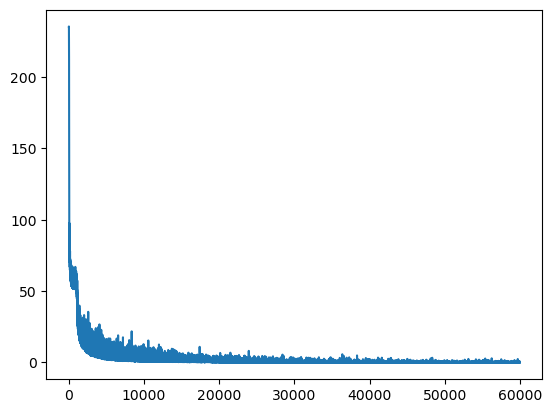

Array(0.08853082, dtype=float32)

In [23]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()
losses[-100:].mean()

In [24]:
# load evaluation task
train_keys = split(TRAIN_KEY,1)
# meta training set (performs well on meta training set):
train_imgs, train_labels, test_imgs, test_labels = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, None,None,None,None,0))((meta_train, meta_train_labels), nr_char, nr_train, nr_test, img_size, 0, train_keys)
# meta testing set (not as good at meta testing set...):
#train_imgs, train_labels, test_imgs, test_labels = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, None,None,None,None,0))((meta_test, meta_test_labels), nr_char, nr_train, nr_test, img_size, 1201, train_keys)

In [25]:
test_model = inner_step_METASGD((model,alpha), train_imgs[0], train_labels[0], batch_loss, inner_optim, inner_opt_state)

792


TypeError: Invalid shape (1, 28, 28) for image data

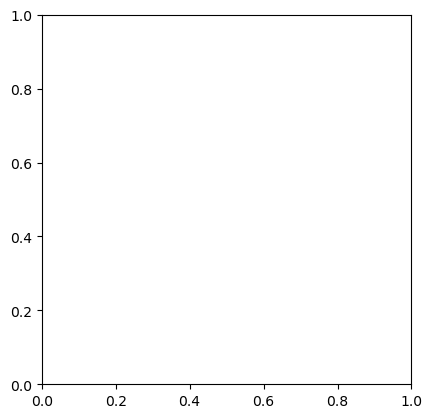

In [26]:
#task, char, image =  0, 0, 2
task, char, image =  0, 4, 12

test_img = test_imgs[task][nr_test*char+image]
test_img_label = test_labels[task][nr_test*char+image]

print(test_img_label)
plt.imshow(test_img)
plt.show()

In [ ]:
pred = sigmoid(test_model(test_img))
print(jnp.argmax(pred))

In [ ]:
a = tree_map(lambda x: print(x), alpha)